# Grab Repository data      

In [1]:

from dotenv import load_dotenv
from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, aggregate_by_date, get_repository_paths
from helper.significance import check_normality_of_buckets, use_normality_results_for_significance_independent
import logging
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

load_dotenv(override=True)

True

In [2]:
REPO_PATHS = os.getenv('STORAGE_DIRECTORIES')
repository_directories = ast.literal_eval(REPO_PATHS) if REPO_PATHS else []
INTRO_DATE = os.getenv('INTRO_DATE')
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')
BUCKET_SIZE = int(os.getenv('BUCKET_SIZE'))
RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
storage_path = f'{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/commits_loc_deleted_per_{BUCKET_SIZE}_days.csv'

# Get only first-level subfolders in the repository directories
repositories = get_repository_paths(repository_directories)

print(repositories)

['/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P3', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P9', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P2', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P8', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P1', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/k1bu0cscd4', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/5x4imrvk5b', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P7', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P5', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P14', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P6', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/bznd2hh7ii', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person

In [3]:
if INTRO_DATE == "":
    import json
    mapping_file = f"{repository_directories[0]}/mapping.json"
    # Check if the file exists
    if not os.path.exists(mapping_file):
        print(f"File not found: {mapping_file}. ")
    with open(mapping_file, 'r') as f:
        mapping = json.load(f)
    print(f"Using INTRO_DATE from mapping file: {INTRO_DATE}")


Using INTRO_DATE from mapping file: 


# Generate Commit Metrics per Repository

## Sum of LOC deleted over time

In [4]:
commit_result = []
aggregation_column = 'loc_deleted'

for repository in repositories:
    if INTRO_DATE == "":
        person = repository.split('/')[-1]
        INTRO_DATE = mapping[person]['INTRO_DATE']
        START_DATE = mapping[person]['START_DATE']
        END_DATE = mapping[person]['END_DATE']
    commit_file = f"{repository}/commits.csv"
    # Check if the file exists
    if not os.path.exists(commit_file):
        print(f"File not found: {commit_file}. Skipping repository.")
        continue
    commit_df = pd.read_csv(commit_file)

    commit_df = truncate_to_same_length(commit_df, INTRO_DATE, 'date', 'defined', START_DATE, END_DATE)
    commit_df = aggregate_by_date(commit_df, 'date', aggregation_column, 'sum')
    
    pre_release, post_release = split_by_date(commit_df, INTRO_DATE, 'date')
    
    pre_release_buckets = generate_value_in_buckets(pre_release, 'date', aggregation_column, 'sum', BUCKET_SIZE, 'pre-')
    post_release_buckets = generate_value_in_buckets(post_release, 'date', aggregation_column, 'sum', BUCKET_SIZE, 'post-')

    release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)

    repo_name = repository.split('/')[-1]
    
    result_row = {'repository': repo_name}
    result_row.update(release_buckets.set_index('bucket')[aggregation_column].to_dict())  # Use 'count' instead of 'value'
    
    commit_result.append(result_row)

# Create the DataFrame
commit_result_df = pd.DataFrame(commit_result)


File not found: /Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants/commits.csv. Skipping repository.


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_65874/4058201673.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)


In [5]:
# Ensure the columns are in the correct order
def sort_buckets(df, prefix_one, prefix_two):
    order = ['repository']
    
    for prefix in [prefix_one, prefix_two]:
        counter = 0
        contained = True
        
        while contained:
            order.append(f'{prefix}{counter}')
            
            counter += 1
            if not f'{prefix}{counter}' in df:
                contained = False
        
    return order

columns_order = sort_buckets(commit_result_df, 'pre-', 'post-')
commit_result_df = commit_result_df[columns_order]

In [6]:

commit_result_df.to_csv(storage_path)
commit_result_df

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P3,5706.0,2376.0,664.0,18548.0,513.0,103.0,886.0,129.0,11233.0,214.0,708.0,13519.0,16035.0,6851.0,NaN,1399.0,518.0,903.0
1,P9,215.0,236.0,58.0,6.0,209.0,388.0,151.0,NaN,93.0,216.0,1232.0,558.0,77.0,12.0,NaN,130.0,71.0,40.0
2,P2,8.0,84.0,19.0,668.0,225.0,135.0,NaN,302.0,NaN,377.0,1053.0,89.0,1145.0,1016.0,NaN,1033.0,109.0,104.0
3,P8,1369.0,902.0,3483.0,1087.0,3581.0,1262.0,1451.0,2426.0,12464.0,3118.0,1940.0,170.0,2068.0,610.0,NaN,17339.0,1841.0,1720.0
4,P1,1185.0,479.0,68.0,1.0,4.0,5.0,3.0,3.0,2.0,0.0,4.0,1.0,0.0,NaN,0.0,NaN,3.0,2.0
5,k1bu0cscd4,0.0,NaN,93.0,NaN,78.0,10.0,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5x4imrvk5b,269.0,479.0,693.0,76.0,326.0,157.0,2361.0,283.0,278.0,311.0,579.0,1883.0,247.0,15.0,121.0,209.0,294.0,109.0
7,P7,217.0,103.0,45.0,402.0,3835.0,10.0,525.0,38.0,NaN,0.0,182.0,280.0,41.0,23.0,2.0,7.0,167.0,208.0
8,P5,750.0,64.0,372.0,NaN,236.0,326.0,NaN,NaN,NaN,3066.0,372.0,460.0,128.0,9972.0,0.0,90.0,929.0,151.0
9,P14,101.0,2370.0,455.0,1549.0,1543.0,3846.0,963.0,824.0,50.0,8350.0,4218.0,156.0,115.0,153.0,76.0,1888.0,167.0,99.0


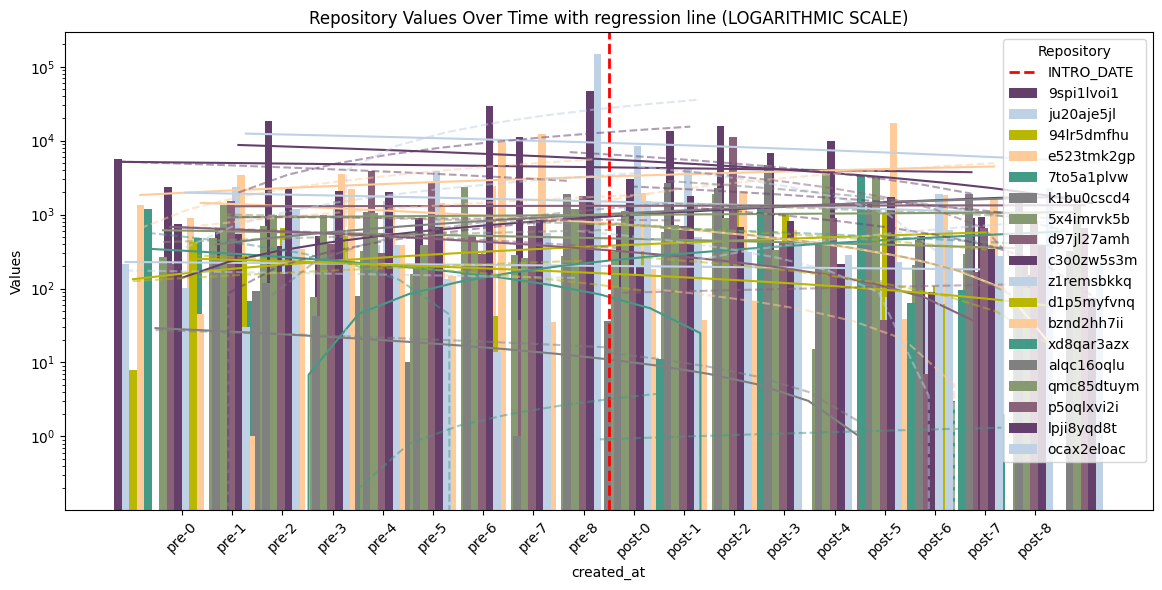

In [7]:
import numpy as np
from scipy.stats import linregress

tangent_data = []

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in commit_result_df.columns if col != 'repository']
colors = ["#FF4500", "#FFA500", "#FF8C00", "#FFD700", "#FF6347", "#FF7F50", "#FFB347", "#FFCC99"]
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#FFCC99", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(commit_result_df['repository']):
    # Extract data for the current repository
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    m, b, _, _, _ = linregress(x, values.values)
    regression_line = m * x + b
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='-', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = commit_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))
    post_0 = 'post-0' if 'post-0' in post_columns else None
    
    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2

        # Vertical red line at midpoint
        plt.axvline(x=midpoint + (len(commit_result_df['repository']) - 1) * bar_width / 2,
                    color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

# Plot bars and regression lines
for i, repo in enumerate(commit_result_df['repository']):
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)

    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, bar_width, label="_nolegend_", color=colors[i % len(colors)])

    if pre_columns and post_columns and largest_pre and post_0:
        # Indices for regression segments
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Extract values
        pre_values = values.values[pre_range]
        post_values = values.values[post_range]

        # Regression before midpoint
        m_pre, b_pre, *_ = linregress(pre_range, pre_values)
        reg_line_pre = m_pre * pre_range + b_pre
        plt.plot(offset_x[pre_range], reg_line_pre, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Regression after midpoint
        m_post, b_post, *_ = linregress(post_range, post_values)
        reg_line_post = m_post * post_range + b_post
        plt.plot(offset_x[post_range], reg_line_post, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Collect regression parameters
        tangent_data.append({
            'repository': repo,
            'm_pre': m_pre,
            'b_pre': b_pre,
            'm_post': m_post,
            'b_post': b_post
        })




# Set x-axis ticks and labels
plt.xticks(x + (len(commit_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()

# Significancetest 

In [8]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Replace NaN values with 0 in the commit_result_df
commit_result_df = commit_result_df.fillna(0)

# Columns for pre and after buckets
pre_columns = [col for col in commit_result_df.columns if col.startswith("pre-")]
after_columns = [col for col in commit_result_df.columns if col.startswith("post-")]

normality_results = check_normality_of_buckets(commit_result_df, pre_columns, after_columns)

# Display the results
print(normality_results)

    repository   pre_p_value  after_p_value  pre_normal  after_normal
0   P3  4.215310e-03   3.168811e-03       False         False
1   P9  5.839960e-01   9.271879e-04        True         False
2   P2  1.083215e-02   1.640548e-02       False         False
3   P8  1.858552e-04   3.715806e-05       False         False
4   P1  5.008587e-05   9.769976e-03       False         False
5   k1bu0cscd4  9.845122e-05   3.217493e-07       False         False
6   5x4imrvk5b  1.588884e-04   3.082694e-04       False         False
7   P7  9.961784e-06   6.344050e-02       False          True
8   P5  1.989000e-02   6.123979e-05       False         False
9   P14  2.406753e-01   4.509920e-04        True         False
10  P6  7.987092e-02   2.693456e-02        True         False
11  bznd2hh7ii  1.387354e-05   9.777972e-04       False         False
12  xd8qar3azx  1.000000e+00   3.230462e-05        True         False
13  P4  8.434105e-04   2.064504e-01       False          True
14  P13  1.077775e-01   2.308

/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [9]:
# from helper.significance import calculate_cliffs_delta_with_confidence, calculate_cliffs_delta
# significance_results_df = calculate_cliffs_delta_with_confidence(commit_result_df, pre_columns, after_columns)
# significance_results_df

In [10]:
from helper.significance import calculate_cliffs_delta_with_confidence
significance_results_df = calculate_cliffs_delta_with_confidence(commit_result_df, pre_columns, after_columns)

# Display the results
print(significance_results_df)

    repository      test_used  effect_size  ci_lower  ci_upper
0   P3  Cliff's Delta     0.037037 -0.506173  0.555556
1   P9  Cliff's Delta    -0.024691 -0.555556  0.506481
2   P2  Cliff's Delta     0.481481 -0.086420  0.876543
3   P8  Cliff's Delta    -0.135802 -0.679012  0.456790
4   P1  Cliff's Delta    -0.765432 -0.987654 -0.394753
5   k1bu0cscd4  Cliff's Delta    -0.234568 -0.604938  0.135802
6   5x4imrvk5b  Cliff's Delta    -0.234568 -0.728395  0.358025
7   P7  Cliff's Delta    -0.296296 -0.777778  0.296296
8   P5  Cliff's Delta     0.469136 -0.086420  0.876543
9   P14  Cliff's Delta    -0.135802 -0.777778  0.407407
10  P6  Cliff's Delta    -0.024691 -0.580247  0.555556
11  bznd2hh7ii  Cliff's Delta    -0.567901 -0.925926 -0.061728
12  xd8qar3azx  Cliff's Delta     0.555556  0.222222  0.888889
13  P4  Cliff's Delta     0.777778  0.358025  1.000000
14  P13  Cliff's Delta    -0.160494 -0.728395  0.432099
15  P12  Cliff's Delta     0.037037 -0.506173  0.604938
16  P10  Cliff's Delta

In [11]:
merged = commit_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,5706.0,2376.0,664.0,18548.0,513.0,103.0,886.0,129.0,11233.0,...,16035.0,6851.0,0.0,1399.0,518.0,903.0,Cliff's Delta,0.037037,-0.506173,0.555556
1,P9,215.0,236.0,58.0,6.0,209.0,388.0,151.0,0.0,93.0,...,77.0,12.0,0.0,130.0,71.0,40.0,Cliff's Delta,-0.024691,-0.555556,0.506481
2,P2,8.0,84.0,19.0,668.0,225.0,135.0,0.0,302.0,0.0,...,1145.0,1016.0,0.0,1033.0,109.0,104.0,Cliff's Delta,0.481481,-0.086420,0.876543
3,P8,1369.0,902.0,3483.0,1087.0,3581.0,1262.0,1451.0,2426.0,12464.0,...,2068.0,610.0,0.0,17339.0,1841.0,1720.0,Cliff's Delta,-0.135802,-0.679012,0.456790
4,P1,1185.0,479.0,68.0,1.0,4.0,5.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,3.0,2.0,Cliff's Delta,-0.765432,-0.987654,-0.394753
5,k1bu0cscd4,0.0,0.0,93.0,0.0,78.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Cliff's Delta,-0.234568,-0.604938,0.135802
6,5x4imrvk5b,269.0,479.0,693.0,76.0,326.0,157.0,2361.0,283.0,278.0,...,247.0,15.0,121.0,209.0,294.0,109.0,Cliff's Delta,-0.234568,-0.728395,0.358025
7,P7,217.0,103.0,45.0,402.0,3835.0,10.0,525.0,38.0,0.0,...,41.0,23.0,2.0,7.0,167.0,208.0,Cliff's Delta,-0.296296,-0.777778,0.296296
8,P5,750.0,64.0,372.0,0.0,236.0,326.0,0.0,0.0,0.0,...,128.0,9972.0,0.0,90.0,929.0,151.0,Cliff's Delta,0.469136,-0.086420,0.876543
9,P14,101.0,2370.0,455.0,1549.0,1543.0,3846.0,963.0,824.0,50.0,...,115.0,153.0,76.0,1888.0,167.0,99.0,Cliff's Delta,-0.135802,-0.777778,0.407407


# Interpretation
- 1, -> less LOC deleted after introduction
- 3 -> more LOC deleted after introduction
- Effect size ranges from medium to big